2024-07-17 18:47:41.583841: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-17 18:47:42.630831: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/pes1ug22am170/.local/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Epoch 1/10, Loss: 0.07401461309442918
Epoch 2/10, Loss: 0.009220090617115298
Epoch 3/10, Loss: 0.0027563663509984813
Epoch 4/10, Loss: 0.0008699882115858296
Epoch 5/10, Loss: 0.0004025669089363267
Epoch 6/10, Loss: 0.000228302468409917
Epoch 7/10, Loss: 0.00014994601588114165
Epoch 8/10, Loss: 0.00011229571585621063
Epoch 9/10, Loss: 9.301022024980436e-05
Epoch 10/10, Loss: 7.853438849754942e-05
Test Loss: 8.833340325509198e-05
Average PSNR: 31.308593045104107
Average SSIM: 0.7599062323570251


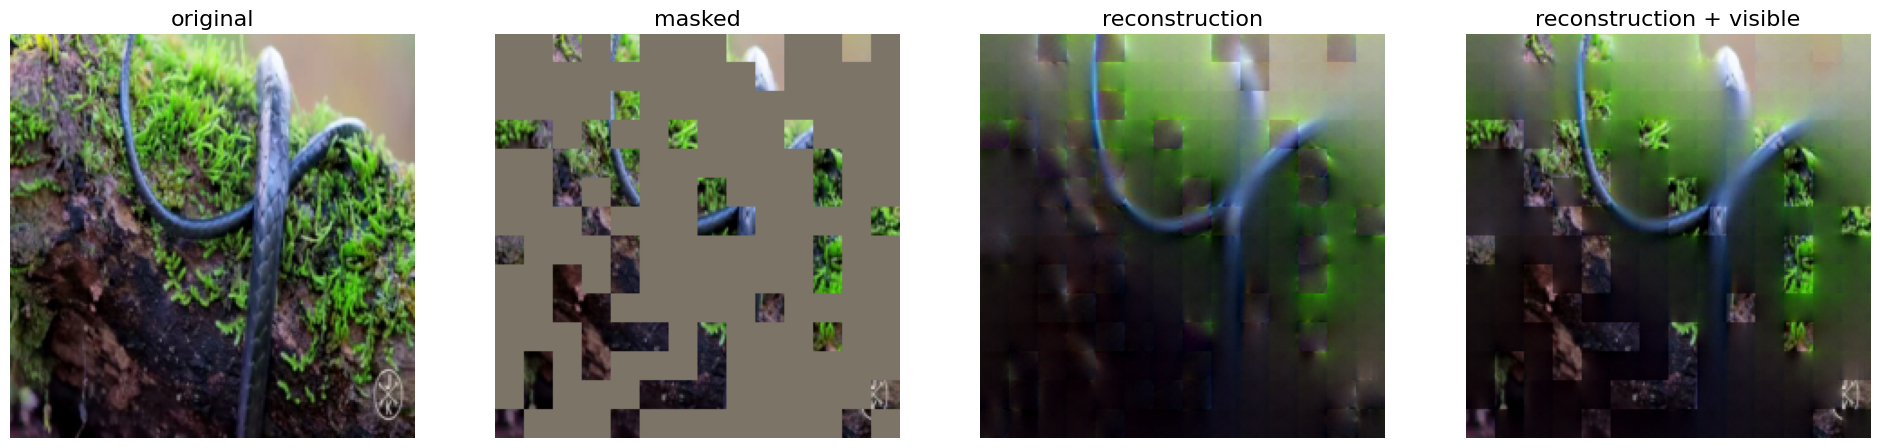

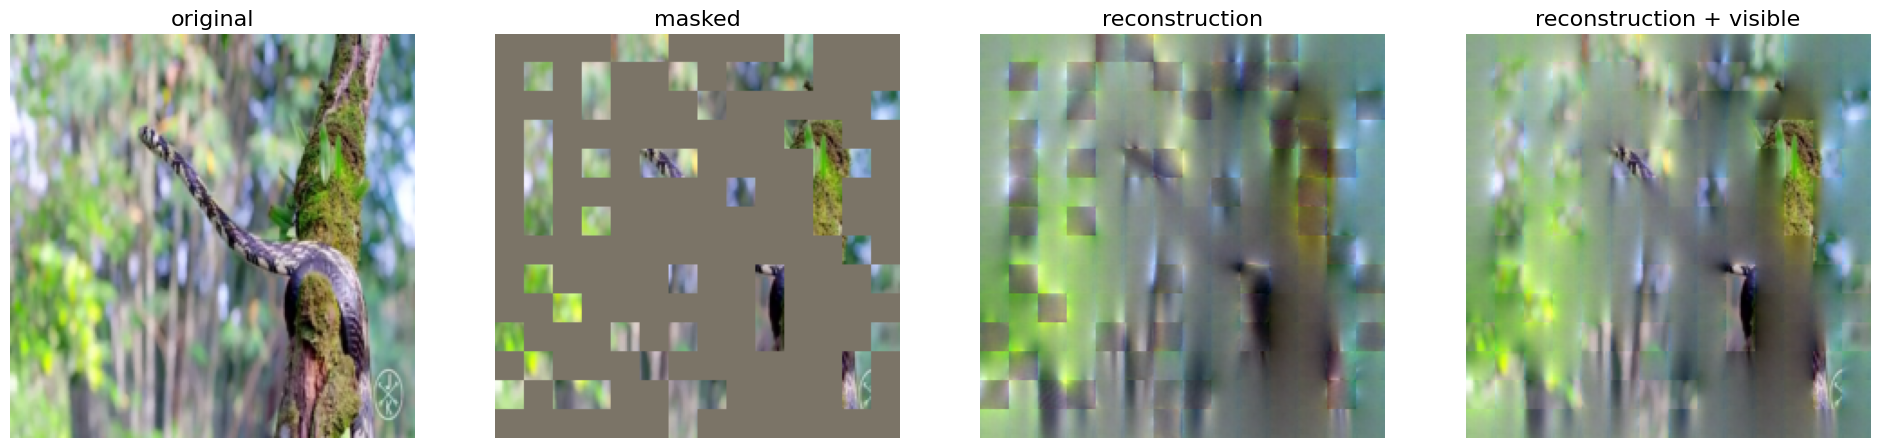

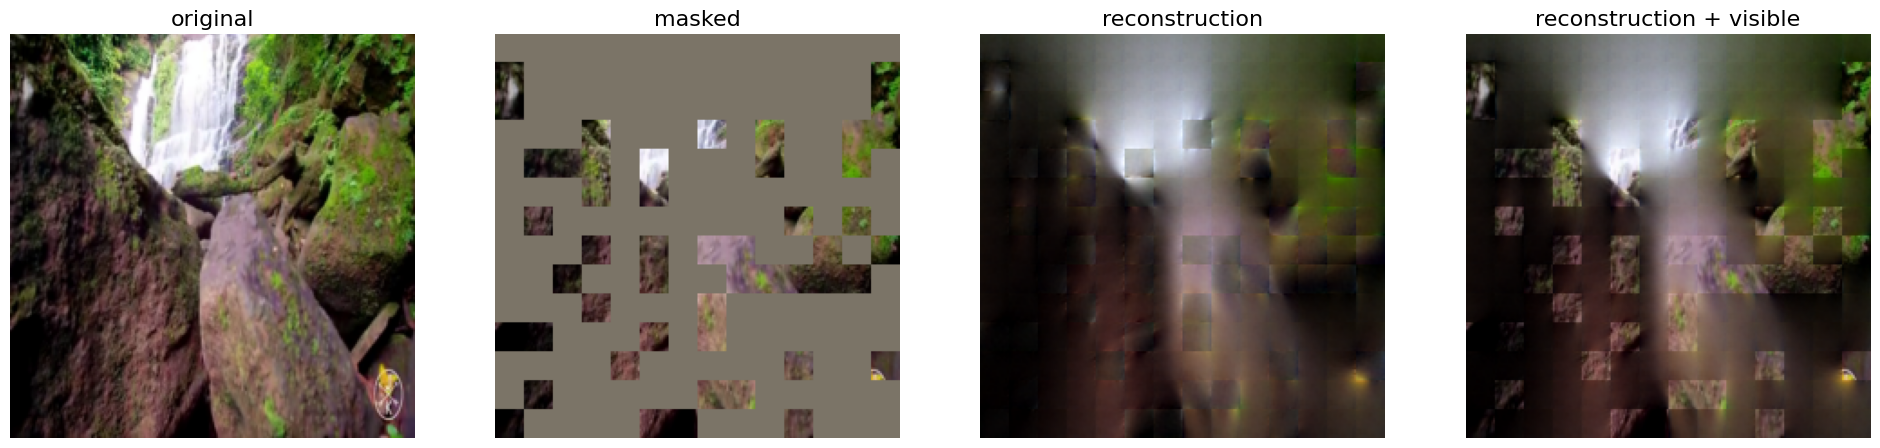

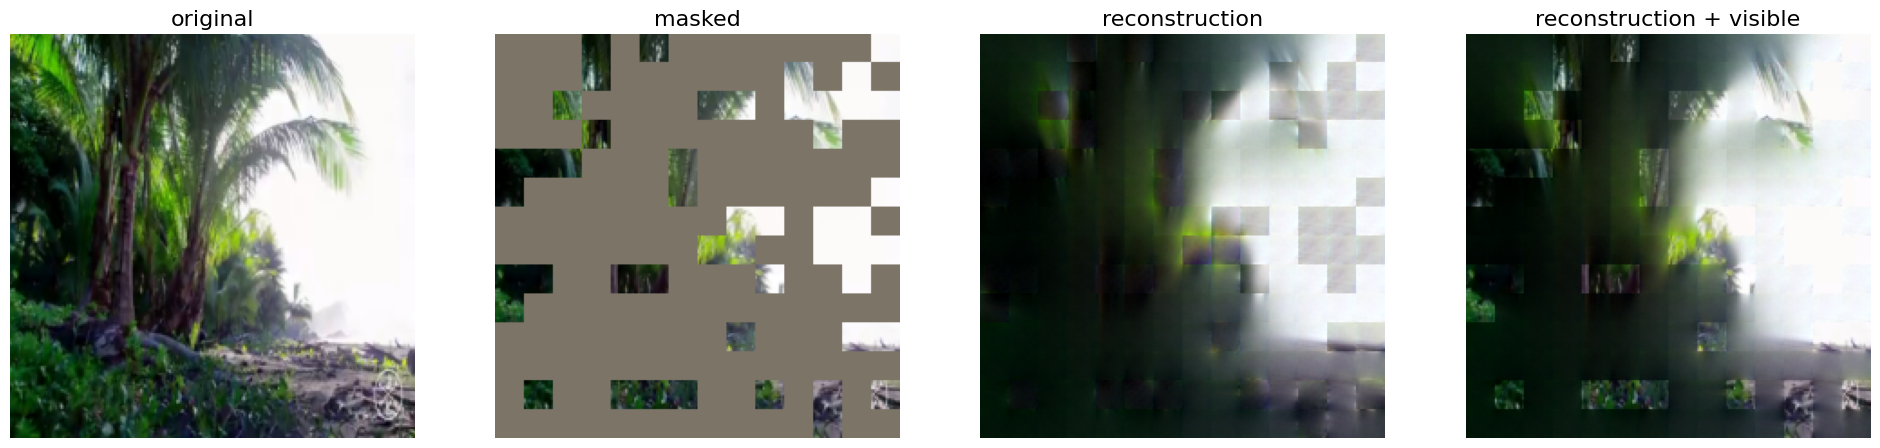

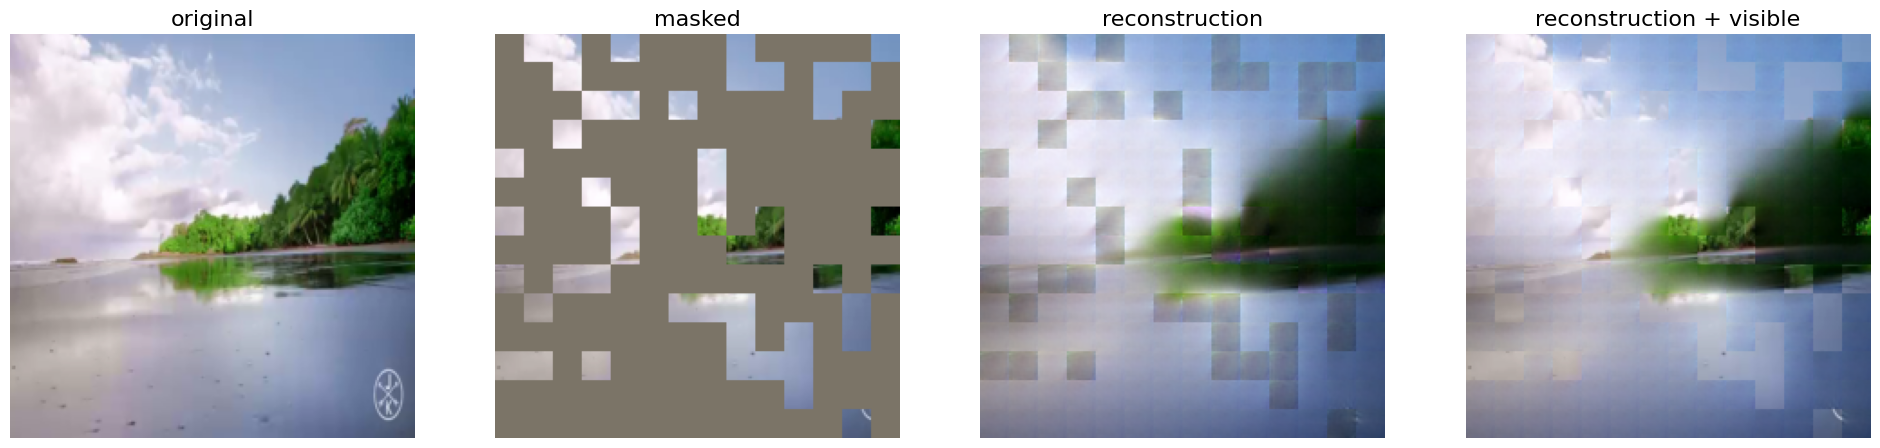

In [1]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import ViTFeatureExtractor, ViTMAEForPreTraining
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR, LambdaLR
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np


# Initialize the feature extractor with do_rescale=False
feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/vit-mae-base")

# Define paths and load model
video_path = "/home/pes1ug22am170/Masked_Vit/COSTA RICA IN 4K 60fps HDR (ULTRA HD).mp4"  # Replace with the actual path to your video file
model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")

# Define hyperparameters
batch_size = 4
num_epochs = 10
learning_rate = 1e-4
weight_decay = 1e-5
step_size = 5
gamma = 0.1
warmup_steps = 15

# Function to show images
imagenet_mean = np.array(feature_extractor.image_mean)
imagenet_std = np.array(feature_extractor.image_std)

def show_image(image, title=''):
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def visualize(pixel_values, model):
    outputs = model(pixel_values)
    y = model.unpatchify(outputs.logits)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    mask = outputs.mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 * 3)
    mask = model.unpatchify(mask)
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', pixel_values)
    im_masked = x * (1 - mask)
    im_paste = x * (1 - mask) + y * mask

    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

# Function to extract frames from a video
def extract_frames(video_path, frame_rate=1):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return []

    frames = []
    success, image = cap.read()
    count = 0
    while success:
        if count % frame_rate == 0:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            frames.append(Image.fromarray(image_rgb))
        success, image = cap.read()
        count += 1
    cap.release()
    return frames

# Define custom dataset class
class FrameDataset(Dataset):
    def __init__(self, frames, feature_extractor):
        self.frames = frames
        self.feature_extractor = feature_extractor
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
            transforms.RandomRotation(15),
            transforms.RandomGrayscale(p=0.1),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        frame = self.frames[idx]
        frame = self.transform(frame)
        # Ensure the frame is in the range [0, 1]
        pixel_values = self.feature_extractor(images=frame, return_tensors="pt").pixel_values.squeeze(0)
        return pixel_values

# Extract frames from the video
frames = extract_frames(video_path, frame_rate=360)

# Split frames into training and test sets
train_frames, test_frames = train_test_split(frames, test_size=0.2, random_state=42)

# Create datasets and dataloaders
train_dataset = FrameDataset(train_frames, feature_extractor)
test_dataset = FrameDataset(test_frames, feature_extractor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Optimizer, scheduler, and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Define a learning rate scheduler with warmup
def lr_lambda(current_step: int):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    return max(0.0, float(num_epochs * len(train_loader) - current_step) / float(max(1, num_epochs * len(train_loader) - warmup_steps)))

scheduler = LambdaLR(optimizer, lr_lambda)

criterion = torch.nn.MSELoss()

# Training loop
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        outputs = model(batch)
        y = model.unpatchify(outputs.logits)
        loss = criterion(y, batch)
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}")

# Save the model
model_save_path = "pred.pth"  # Replace with your desired path
torch.save(model.state_dict(), model_save_path)

def calculate_metrics(original, reconstructed):
    original = original.permute(0, 2, 3, 1).cpu().numpy()
    reconstructed = reconstructed.permute(0, 2, 3, 1).cpu().numpy()
    data_range = original.max() - original.min()
    psnr = np.mean([peak_signal_noise_ratio(o, r, data_range=data_range) for o, r in zip(original, reconstructed)])
    
    # Explicitly setting win_size and channel_axis for SSIM calculation
    ssim = np.mean([
        structural_similarity(o, r, data_range=data_range, multichannel=True, win_size=7, channel_axis=-1)
        for o, r in zip(original, reconstructed)
    ])
    
    return psnr, ssim

# Evaluate on test set
model.eval()
test_loss = 0
psnr_total = 0
ssim_total = 0
with torch.no_grad():
    for batch in test_loader:
        outputs = model(batch)
        y = model.unpatchify(outputs.logits)
        loss = criterion(y, batch)
        test_loss += loss.item()

        psnr, ssim = calculate_metrics(batch, y)
        psnr_total += psnr
        ssim_total += ssim

test_loss /= len(test_loader)
psnr_total /= len(test_loader)
ssim_total /= len(test_loader)

print(f"Test Loss: {test_loss}")
print(f"Average PSNR: {psnr_total}")
print(f"Average SSIM: {ssim_total}")

# Visualize a few test samples
for idx, frame in enumerate(test_frames[:5]):
    pixel_values = feature_extractor(images=frame, return_tensors="pt").pixel_values
    visualize(pixel_values, model)